<a href="https://colab.research.google.com/github/ysurs/Vit/blob/main/ViT_paper_experimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Basic imports

In [1]:
!pip install -q torchinfo

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchinfo import summary
from PIL import Image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
import PIL

In [5]:
import os
import zipfile

from pathlib import Path

import requests

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Getting data and storing it in folder

In [7]:
# Getting the data and returning image dataset path
# Taken as is from Daniel Bourke's Pytorch from zero to mastery

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    

    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [8]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Single image transformation

In [9]:
# transforming images to suit the needs of ViT

image_size=224

transform=transforms.Compose([transforms.Resize((image_size,image_size)),transforms.ToTensor()])



In [10]:
single_image=Image.open('/content/data/pizza_steak_sushi/train/pizza/1008844.jpg')

In [11]:

transform(single_image).shape

torch.Size([3, 224, 224])

****

### Creating DataLoaders

In [12]:
import os
NUM_WORKERS = os.cpu_count()

In [13]:
NUM_WORKERS

2

In [14]:
# Taken as is from Daniel Bourke's Pytorch from zero to mastery

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.
  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.
  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.
  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [15]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=transform, 
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f3166c817e0>,
 ['pizza', 'steak', 'sushi'])

****

### Inspecting the dataloaders

In [16]:
for i in train_dataloader:
  first_batch=i
  break

In [17]:
type(first_batch)

list

In [18]:

first_batch[1][0]

tensor(2)

In [19]:
trans=(transforms.ToPILImage()(first_batch[0][0]))

In [20]:
first_batch[0][0].shape

torch.Size([3, 224, 224])

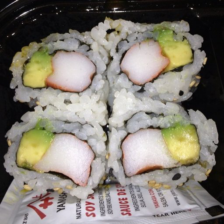

In [21]:
# This is the fist image 
trans.show()

### Another way to visualize samples from dataloaders

In [22]:
images_batch,labels_batch=next(iter(train_dataloader))

In [23]:
# First batch of 32 elements
labels_batch

tensor([1, 0, 2, 2, 2, 1, 0, 0, 0, 2, 0, 1, 2, 2, 0, 0, 0, 2, 2, 2, 0, 1, 2, 2,
        2, 1, 0, 0, 0, 1, 0, 1])

In [24]:
# First batch of 32 images
images_batch.shape

torch.Size([32, 3, 224, 224])

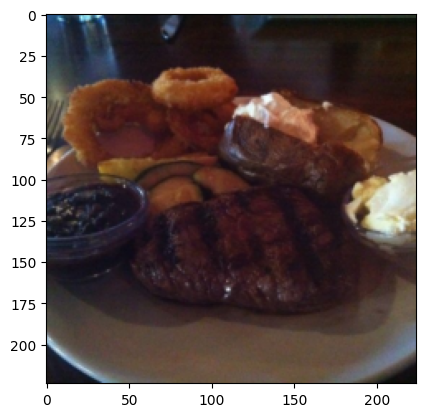

In [25]:
### Using matplotlib's imshow. We will have to permute the shape from channels, height, width to height,width, channels to use with imshow

plt.imshow(torch.permute(images_batch[0],(1,2,0)))

In [26]:
class_names[labels_batch[0]]

'steak'

***

### We will be coding up these equations and will be referencing the architecture also

\begin{aligned}
\mathbf{z}_0 & =\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D} \\
\mathbf{z}_{\ell}^{\prime} & =\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \\
\mathbf{z}_{\ell} & =\operatorname{MLP}\left(\mathrm{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\mathbf{y} & =\operatorname{LN}\left(\mathbf{z}_L^0\right) & &
\end{aligned}

### Creating patches from images- Sorting out the shapes first

In [27]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

number_of_patches = int((height * width) / patch_size**2)
print(f"No of patches is {number_of_patches}")

image_input_shape=(height,width,color_channels)
image_to_patches_shape=(number_of_patches,(patch_size**2)*color_channels)

print(f'the shape of input image is {image_input_shape}')
print(f'the shape of input image after patching is {image_to_patches_shape}')

No of patches is 196
the shape of input image is (224, 224, 3)
the shape of input image after patching is (196, 768)


#### For processing inside our model, we will have to convert patches which are still of shape 16X16 into embeddings. The embedding length for each patch will be 16X16X3 which is 768. So each patch will be embedded in a tensor of length 768.

#### (196,768) tells us that each image should be converted into 196 patches where each patch is represented by a tensor of shape [768]

#### Visualising a rectangular patch

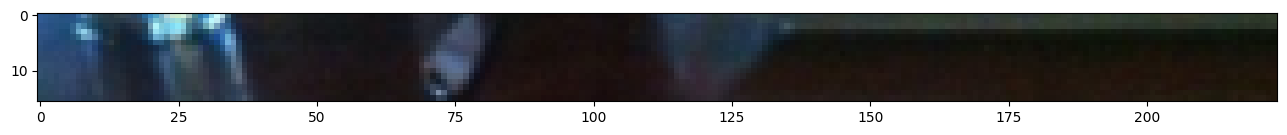

In [28]:
image_permuted = images_batch[0].permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size,:,:]);

#### Breaking down the above into smaller patches

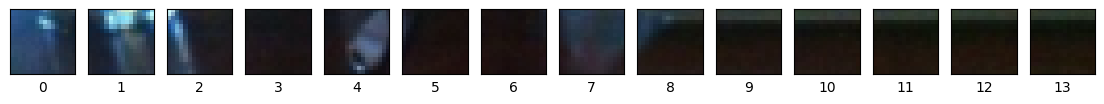

In [29]:
image_size=224
patch_size=16
num_patches=image_size/patch_size

# Create a series of subplots
fig, axs = plt.subplots(nrows=1, 
                        ncols=image_size // patch_size, 
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)


for i, patch in enumerate(range(0, 224, patch_size)):
  axs[i].imshow(image_permuted[:patch_size,patch:patch+patch_size,:])
  axs[i].set_xlabel(f'{i}')
  axs[i].set_xticks([])
  axs[i].set_yticks([])

#### Each row of the image gives us 14 patches

#### Now we have patches of shape 16X16.

#### Like this, the whole image needs to be converted into patches- this is the process of patchification.

****

### In the next step, we need to change these patches into embeddings

The operation which we just performed is similar to the process of applying convolution operation on the image.

In [30]:
conv=nn.Conv2d(in_channels=3,out_channels=768,padding=0,kernel_size=patch_size,stride=patch_size)

## Note: I have understood why the out_channels is equal to 768

In [31]:
# Pass the image through the convolutional layer 
image_out_of_conv = conv(images_batch[0].unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [32]:
# In turn, taking the number of feature maps equal to 768 in above equation has given us a resultant feature map of 14X14. Each block in this matrix
# is represented by a tensor of shape 768. This is equivalent to the unrolling operation.
image_out_of_conv[0,:,1,13].shape

torch.Size([768])

The height and width of feature maps is 14,14

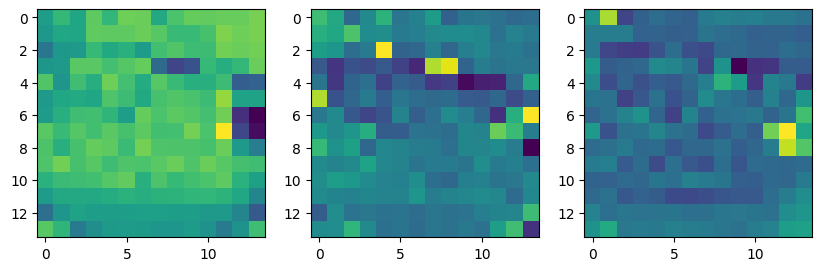

In [33]:
## Lets visualize some feature maps

import random 

random_indices=random.sample(range(0,767),3)

fig,axes=plt.subplots(nrows=1,ncols=3, figsize=(10,10))

for i, idx in enumerate(random_indices):
  feature_map=image_out_of_conv[:,idx,:,:].squeeze().detach().numpy()
  axes[i].imshow(feature_map)



### These feature maps are nothing but learnable embeddings 

## In the above cells, we saw the unrolling operation i.e how to convert patches into embeddings. Now we want to flatten the patches to get the embeddings into correct shape

In [34]:
### Flattening patch embeddings to get shape: (196,768)

# Lets see what we have now:
print(image_out_of_conv.shape)


torch.Size([1, 768, 14, 14])


### The above represents a feature map of dimension 14X14. Each cell of the feature map is represented by a tensor of shape 768. This in turn is telling us that each cell in the feature map is the embedding representing each patch of the image

In [35]:
image_out_of_conv_reshaped=image_out_of_conv.view(1,768,196)

In [36]:
# This tells us that our image has been broken down into 196 patches and each patch is represented by an embedding of size 768
image_out_of_conv_reshaped.shape

torch.Size([1, 768, 196])

In [37]:
# A bit of rearrangement of tensor

image_out_of_conv_rearranged=image_out_of_conv_reshaped.permute(0,2,1)

In [38]:
image_out_of_conv_rearranged.shape

torch.Size([1, 196, 768])

### This looks more like the expected input tensor which needs to be passed inside ViT

*****

### Alternative approach to patching i.e without convolution

In [39]:
image_unsqeezed=torch.unsqueeze(images_batch[0],dim=0)

In [40]:
image_unsqeezed.shape

torch.Size([1, 3, 224, 224])

In [41]:
n, c, h, w = image_unsqeezed.shape

assert h == w, "Patchify method is implemented for square images only"

patches = torch.zeros(n, 14 ** 2, h * w * c // (14 ** 2))
patch_size = 16

for idx, image in enumerate(image_unsqeezed):
    for i in range(14):
        for j in range(14):
            patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size] ## get all color channels and a patch from the image
            print(patch.shape)
            patches[idx, i * 14 + j] = patch.flatten() # This will flatten pathces into a 1d tensor
            print(idx, i * 14 + j)

torch.Size([3, 16, 16])
0 0
torch.Size([3, 16, 16])
0 1
torch.Size([3, 16, 16])
0 2
torch.Size([3, 16, 16])
0 3
torch.Size([3, 16, 16])
0 4
torch.Size([3, 16, 16])
0 5
torch.Size([3, 16, 16])
0 6
torch.Size([3, 16, 16])
0 7
torch.Size([3, 16, 16])
0 8
torch.Size([3, 16, 16])
0 9
torch.Size([3, 16, 16])
0 10
torch.Size([3, 16, 16])
0 11
torch.Size([3, 16, 16])
0 12
torch.Size([3, 16, 16])
0 13
torch.Size([3, 16, 16])
0 14
torch.Size([3, 16, 16])
0 15
torch.Size([3, 16, 16])
0 16
torch.Size([3, 16, 16])
0 17
torch.Size([3, 16, 16])
0 18
torch.Size([3, 16, 16])
0 19
torch.Size([3, 16, 16])
0 20
torch.Size([3, 16, 16])
0 21
torch.Size([3, 16, 16])
0 22
torch.Size([3, 16, 16])
0 23
torch.Size([3, 16, 16])
0 24
torch.Size([3, 16, 16])
0 25
torch.Size([3, 16, 16])
0 26
torch.Size([3, 16, 16])
0 27
torch.Size([3, 16, 16])
0 28
torch.Size([3, 16, 16])
0 29
torch.Size([3, 16, 16])
0 30
torch.Size([3, 16, 16])
0 31
torch.Size([3, 16, 16])
0 32
torch.Size([3, 16, 16])
0 33
torch.Size([3, 16, 16])


In [42]:
patches.shape

torch.Size([1, 196, 768])

In [43]:
patch_size

16

****
## The flattened patches need to be passed through a linear layer

In [44]:
# We have matrix of the following shape
patches[0,:,:].shape

torch.Size([196, 768])

In [45]:
# If we pass the patches through the linear layer, it means matrix multiplication. 

patches_after_linear_projection=nn.Linear(768,384)(patches)

In [46]:
# The linear operation happens only at the last dimension
patches_after_linear_projection.shape

torch.Size([1, 196, 384])

****
## According to the architecture, we must now add a CLS token as well

In [47]:
# This representation will be learnable
cls_token=nn.Parameter(torch.ones((1,1,384)))

In [48]:
# The shape is 1,1,384 because a cls token is present per image hence the first 1, the second 1 because only 1 token needs to be added, 384 because the patch embeddings are of the same shape
cls_token.shape

torch.Size([1, 1, 384])

In [49]:
patch_embedding_with_cls=torch.cat((cls_token,patches_after_linear_projection),dim=1)

In [50]:
patch_embedding_with_cls[0,:10,:]

tensor([[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
        [-0.0187, -0.0369,  0.0543,  ..., -0.4242,  0.0988, -0.1433],
        [-0.0284, -0.0952, -0.0576,  ..., -0.5376,  0.0155, -0.0886],
        ...,
        [-0.0076,  0.0238,  0.0221,  ..., -0.0399, -0.0032, -0.0220],
        [ 0.0017, -0.0084,  0.0468,  ..., -0.1918, -0.0125, -0.0726],
        [ 0.0315, -0.0485, -0.0098,  ..., -0.1714,  0.0556, -0.0029]],
       grad_fn=<SliceBackward0>)

### As you can see, the first embedding has all ones. This is the cls token embedding

### Note: I have intialized the cls token using torch.ones but in reality this should be done using torch.randn

****
## Adding positional encoding

In [51]:
## Taken from https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c

def get_positional_embeddings(sequence_length, d):
    
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

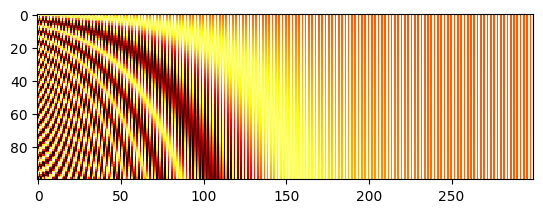

In [52]:
plt.imshow(get_positional_embeddings(100, 300), cmap="hot", interpolation="nearest")
plt.show()

**Note**: about positional encoding: The positional encoding is a function of number of elements in the sequence and the dimensionality of the embedding for each element. In our case, the number of elements are patches and embedding is the embedding for each patch

Note: For each patch i, we add to its embedding value at j either sin(freq) or cos(freq) depending on the position of the value

Note: As we can see, all horizontal lines are unique in the diagram, we want this

In [53]:
positional_embedding=nn.Parameter(torch.tensor(get_positional_embeddings(196+1, 384)))

<ipython-input-53-7fc9d45b58b4>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  positional_embedding=nn.Parameter(torch.tensor(get_positional_embeddings(196+1, 384)))


In [54]:
positional_embedding=torch.unsqueeze(positional_embedding,dim=0)

In [55]:
positional_embedding.shape

torch.Size([1, 197, 384])

In [56]:
positional_embedding_with_patches_and_cls=patch_embedding_with_cls+positional_embedding

In [57]:
positional_embedding_with_patches_and_cls.shape

torch.Size([1, 197, 384])

In [58]:
positional_embedding_with_patches_and_cls[0,:10,:]

tensor([[ 1.0000,  2.0000,  1.0000,  ...,  2.0000,  1.0000,  2.0000],
        [ 0.8228,  0.5034,  0.8696,  ...,  0.5758,  0.0989,  0.8567],
        [ 0.8809, -0.5114,  0.8866,  ...,  0.4624,  0.0157,  0.9114],
        ...,
        [ 0.6494,  0.7777,  0.4013,  ...,  0.9601, -0.0025,  0.9780],
        [ 0.9910, -0.1539,  1.0208,  ...,  0.8082, -0.0116,  0.9274],
        [ 0.4437, -0.9596,  0.7390,  ...,  0.8286,  0.0566,  0.9971]],
       grad_fn=<SliceBackward0>)

### Now we have patches for one image along with cls token at the start. We have also added positional encoding for each token

### We can also look at the tensor at 0th index

**** 
### Now , we have patchifying mechanism, positional encoding, cls token.

### We now what the transformer encoder

*****

### Before building encoder, lets understand layer normalisation


Layer normalisation will normalize along the feature dimension. In simple terms, layer normalization rescales and shifts the values of the input tensor such that the mean is zero and the standard deviation is one across the features of each sample. This process is performed independently for each sample in the batch and for each feature in the sample.

In [59]:
import torch
import torch.nn as nn

# create a random input tensor with shape (batch_size=2, sequence_length=3, feature_dim=4)
x = torch.randn((2, 3, 4))

# define a layer normalization module for input tensor with feature_dim=4
ln = nn.LayerNorm(x.size()[2])

# apply layer normalization to input tensor x
x_normalized = ln(x)

# print the mean and standard deviation of x along the feature dimension
print("Mean of x along feature dimension:", torch.mean(x, dim=-1))
print("Standard deviation of x along feature dimension:", torch.std(x, dim=-1))

# print the mean and standard deviation of the normalized tensor x_normalized along the feature dimension
print("Mean of x_normalized along feature dimension:", torch.mean(x_normalized, dim=-1))
print("Standard deviation of x_normalized along feature dimension:", torch.std(x_normalized, dim=-1))


Mean of x along feature dimension: tensor([[-0.2442, -0.7839,  0.6222],
        [ 0.9323,  0.4014,  0.3585]])
Standard deviation of x along feature dimension: tensor([[0.4118, 0.6819, 0.9258],
        [0.6697, 0.2667, 0.8426]])
Mean of x_normalized along feature dimension: tensor([[ 0.0000e+00, -2.9802e-08, -5.9605e-08],
        [-8.9407e-08,  0.0000e+00,  3.7253e-08]], grad_fn=<MeanBackward1>)
Standard deviation of x_normalized along feature dimension: tensor([[1.1547, 1.1547, 1.1547],
        [1.1547, 1.1546, 1.1547]], grad_fn=<StdBackward0>)


### Understanding mean and std along the last dimension.

In [60]:
x

tensor([[[ 0.1747, -0.1146, -0.2305, -0.8066],
         [-1.1404, -1.4524, -0.6558,  0.1131],
         [ 1.3403,  0.4360,  1.3255, -0.6132]],

        [[ 1.1779,  1.4244,  1.1841, -0.0574],
         [ 0.4113,  0.3418,  0.1035,  0.7491],
         [ 0.4614,  1.3744, -0.6811,  0.2791]]])

In [61]:
torch.mean(x,dim=2)

tensor([[-0.2442, -0.7839,  0.6222],
        [ 0.9323,  0.4014,  0.3585]])

In [62]:
(1.4581+1.8807)/2

1.6694

In [63]:
(1.4581+-0.7313+2.1723)/3

0.9663666666666666

In [64]:
(-0.7313 + -0.4717 + 1.2899 +-0.2260)/4

-0.03477499999999995

### To summarize, what layer normalisation does is, for each feature in a sample, in our case for each patch embedding, normalisation is performed such that the embeddings for a patch are normalized

****
## In comes mulithead attention: Not the most optimal but very helpful for learning

In [84]:
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)

        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            print(sequence.shape)
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                print(seq.shape)
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
                print(seq_result)
            result.append(torch.hstack(seq_result))
            print(result)
            print(result[0].shape)
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

In [85]:
random_sequence=torch.randn(2,5,8)

In [86]:
mha=MyMSA(8)

In [87]:
# Each of the heads will focus on different subsection of the input tensor. First head will focus on first subsection on length 4 and the second head will focus on 2nd subsection
mha_result=mha(random_sequence)

torch.Size([5, 8])
torch.Size([5, 4])
[tensor([[0.3562, 0.3560, 0.4727, 0.3514],
        [0.4659, 0.4338, 0.4955, 0.4257],
        [0.4559, 0.4116, 0.4787, 0.4177],
        [0.4538, 0.4213, 0.4983, 0.4171],
        [0.3245, 0.3232, 0.4394, 0.3293]], grad_fn=<MmBackward0>)]
torch.Size([5, 4])
[tensor([[0.3562, 0.3560, 0.4727, 0.3514],
        [0.4659, 0.4338, 0.4955, 0.4257],
        [0.4559, 0.4116, 0.4787, 0.4177],
        [0.4538, 0.4213, 0.4983, 0.4171],
        [0.3245, 0.3232, 0.4394, 0.3293]], grad_fn=<MmBackward0>), tensor([[-0.6987, -0.3861,  0.0462, -0.2507],
        [-0.9579, -0.3200, -0.0756, -0.7484],
        [-0.8528, -0.3386, -0.0229, -0.5541],
        [-0.8952, -0.3241, -0.0410, -0.6401],
        [-1.2561, -0.2901, -0.2260, -1.3326]], grad_fn=<MmBackward0>)]
[tensor([[ 0.3562,  0.3560,  0.4727,  0.3514, -0.6987, -0.3861,  0.0462, -0.2507],
        [ 0.4659,  0.4338,  0.4955,  0.4257, -0.9579, -0.3200, -0.0756, -0.7484],
        [ 0.4559,  0.4116,  0.4787,  0.4177, -0.852

In [90]:
mha_result

tensor([[[ 0.3562,  0.3560,  0.4727,  0.3514, -0.6987, -0.3861,  0.0462,
          -0.2507],
         [ 0.4659,  0.4338,  0.4955,  0.4257, -0.9579, -0.3200, -0.0756,
          -0.7484],
         [ 0.4559,  0.4116,  0.4787,  0.4177, -0.8528, -0.3386, -0.0229,
          -0.5541],
         [ 0.4538,  0.4213,  0.4983,  0.4171, -0.8952, -0.3241, -0.0410,
          -0.6401],
         [ 0.3245,  0.3232,  0.4394,  0.3293, -1.2561, -0.2901, -0.2260,
          -1.3326]],

        [[-0.0898,  0.5053,  0.6558,  0.2381, -0.5295, -0.3849,  0.3082,
          -0.7981],
         [-0.1474,  0.5486,  0.5988,  0.3148, -0.2112, -0.4634,  0.4639,
          -0.2154],
         [-0.1423,  0.5892,  0.5708,  0.2979, -0.4851, -0.4137,  0.3267,
          -0.7112],
         [-0.1068,  0.6087,  0.5651,  0.2617, -0.5688, -0.3632,  0.2926,
          -0.8791],
         [-0.0774,  0.4833,  0.6777,  0.2144, -0.1831, -0.4298,  0.4876,
          -0.1861]]], grad_fn=<CatBackward0>)

### We can see how this is being concatenated by inspecting above results


In [70]:
mha_result.shape

torch.Size([1, 5, 8])

In [71]:
# We have 2 heads, each head will have its own qkv matrix.
# These matrices are nothing but leaner layers. A sequence is of length 8, since we have 2 heads, 1st head will work on the inital 4 elements and the next head will work on the next 4 elements.
# Due to this reason, the in_feature=4
mha.d,mha.q_mappings,mha.k_mappings,mha.v_mappings,mha.d_head


(8,
 ModuleList(
   (0-1): 2 x Linear(in_features=4, out_features=4, bias=True)
 ),
 ModuleList(
   (0-1): 2 x Linear(in_features=4, out_features=4, bias=True)
 ),
 ModuleList(
   (0-1): 2 x Linear(in_features=4, out_features=4, bias=True)
 ),
 4)

# Note : We have the primary ingredients for implementation, now formalising it.